<center>
<img src="logo.png" height="900"> 
</center>

# <center> Анализ временных рядов в Python</center>


# План:

1. Движемся, сглаживаем и оцениваем
    - Rolling window estimations
    - Экспоненциальное сглаживание, модель Хольта-Винтерса
    - Кросс-валидация на временных рядах, подбор параметров
2. Эконометрический подход
    - Стационарность, единичные корни
    - Избавляемся от нестационарности и строим SARIMA
3. Линейные и не очень модели на временных рядах
    - Извлечение признаков (Feature extraction)
    - Линейная регрессия vs XGBoost

# Движемся, сглаживаем и оцениваем



Импортируем нужные библиотеки. В основном нам понадобится модуль  [statsmodels](http://statsmodels.sourceforge.net/stable/), в котором реализованы многочисленные методы статистического моделирования, в том числе для временных рядов. 

In [1]:
import sys
import warnings

warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

%matplotlib inline


from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

Для примера возьмем реальные данные по часовому онлайну игроков в одной из мобильных игрушек

In [2]:
dataset = pd.read_csv(
    "D:/tex/Python/TS/hour_online.csv", index_col=["Time"], parse_dates=["Time"]
)
plotly_df(dataset, title="Online users")

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [3]:
def moving_average(series, n):
    return np.average(series[-n:])


moving_average(
    dataset.Users, 24
)  # посмотрим на прогноз, построенный по последнему наблюдаемому дню (24 часа)

29858.333333333332

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

In [4]:
def plotMovingAverage(series, n, plot_bounds=False):

    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """

    rolling_mean = series.rolling(window=n).mean()

    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_mean + 1.96 * rolling_std
        lower_bound = rolling_mean - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    # Деления соответствуют понедельникам что дает представление о недельной цикличности графика
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    # Отображать значение дат в формате yy-mm-dd
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
    plt.xticks(rotation=45)

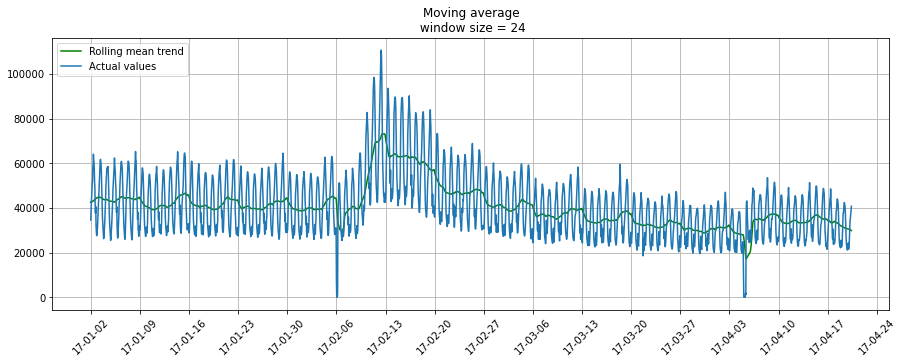

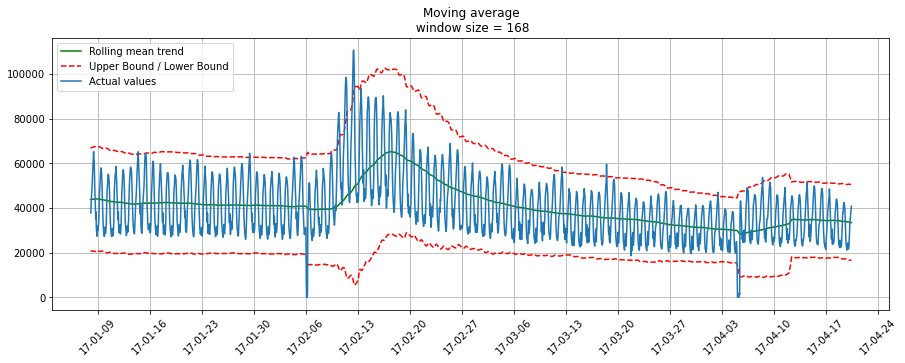

In [5]:
plotMovingAverage(dataset, 24)  # сглаживаем по дням
plotMovingAverage(dataset, 24 * 7, plot_bounds=True)  # сглаживаем по неделям

Для нашего ряда тренды и так вполне очевидны, но если сгладить по дням, становится лучше видна динамика онлайна по будням и выходным (выходные - время поиграть), а недельное сглаживание хорошо отражает общие изменения, связанные с резким ростом числа активных игроков в феврале и последующим снижением в марте.

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в суме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [6]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [7]:
weighted_average(dataset.Users, [0.6, 0.2, 0.1, 0.07, 0.03])

39907.43

## Экспоненциальное сглаживание

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

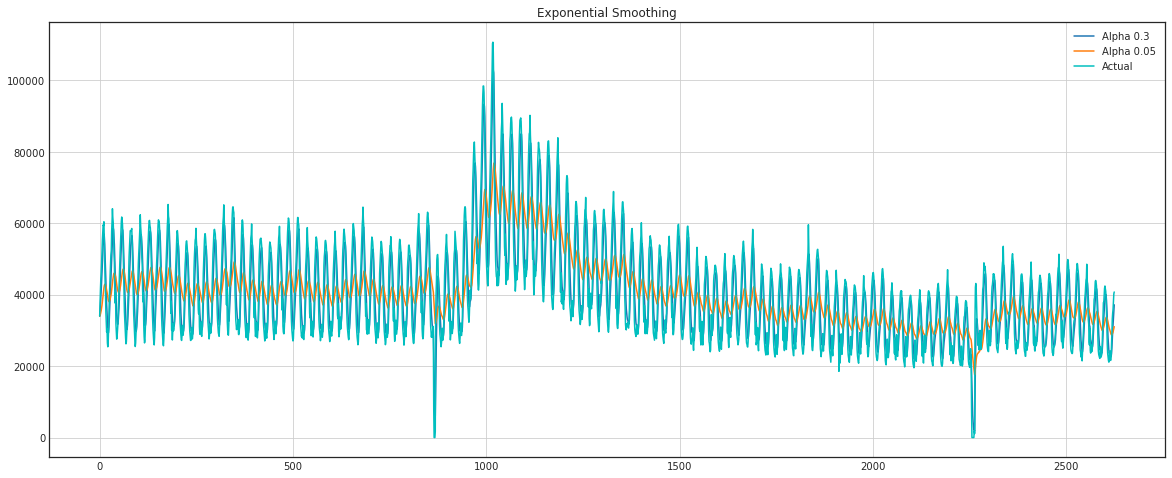

In [9]:
with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(
            exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha)
        )
    plt.plot(dataset.Users.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)

## Двойное экспоненциальное сглаживание

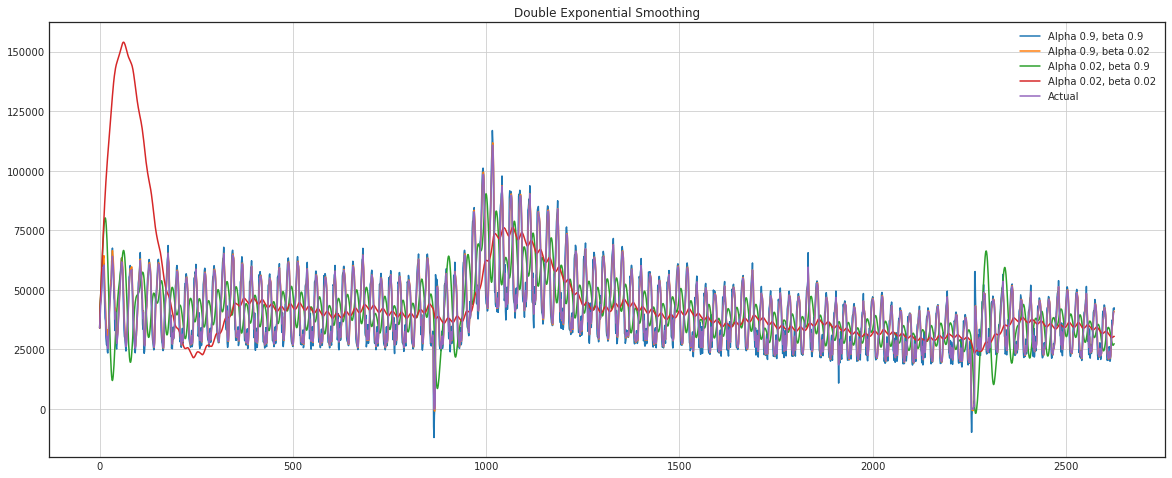

In [10]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(
                double_exponential_smoothing(dataset.Users, alpha, beta),
                label="Alpha {}, beta {}".format(alpha, beta),
            )
    plt.plot(dataset.Users.values, label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Теперь настраивать пришлось уже два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. А о не ручном подборе параметров расскажу чуть ниже, сразу после тройного экспоненциального сглаживания.

## Экспоненциальное сглаживание Holt-Winters



In [11]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series):  # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

## Кросс-валидация на временных рядах

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Код для кросс-валидации на временном ряду. Значение длины сезона 24\*7 возникло не случайно - в исходном ряде отчетливо видна дневная сезонность, (отсюда 24), и недельная - по будням ниже, на выходных - выше, (отсюда 7), суммарно сезонных компонент получится 24\*7.

In [12]:
from sklearn.model_selection import TimeSeriesSplit


def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=24 * 7,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров - каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае - Truncated Newton conjugate gradient.

In [13]:
%%time
data = dataset.Users[:-500]  # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006635880294816432 0.0 0.046569454900318885
Wall time: 8.45 s


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов)

In [14]:
# Передаем оптимальные значения модели,
data = dataset.Users
model = HoltWinters(
    data[:-128],
    slen=24 * 7,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=128,
    scaling_factor=2.56,
)
model.triple_exponential_smoothing()

Код для отрисовки графика

In [15]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN] * len(data))
    Anomalies[data.values < model.LowerBond] = data.values[
        data.values < model.LowerBond
    ]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(
        x=range(0, len(model.result)),
        y1=model.UpperBond,
        y2=model.LowerBond,
        alpha=0.5,
        color="grey",
    )
    plt.plot(data.values, label="Actual")
    plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 128, len(data), alpha=0.5, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

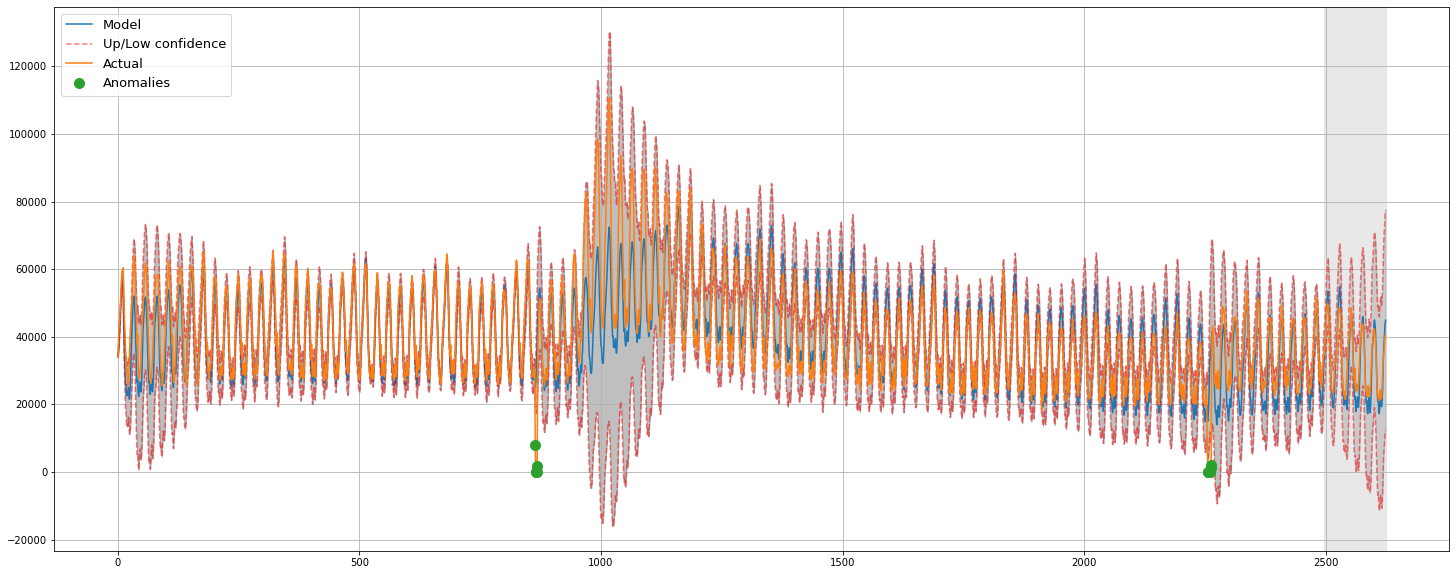

In [16]:
plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив недельную и дневную сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

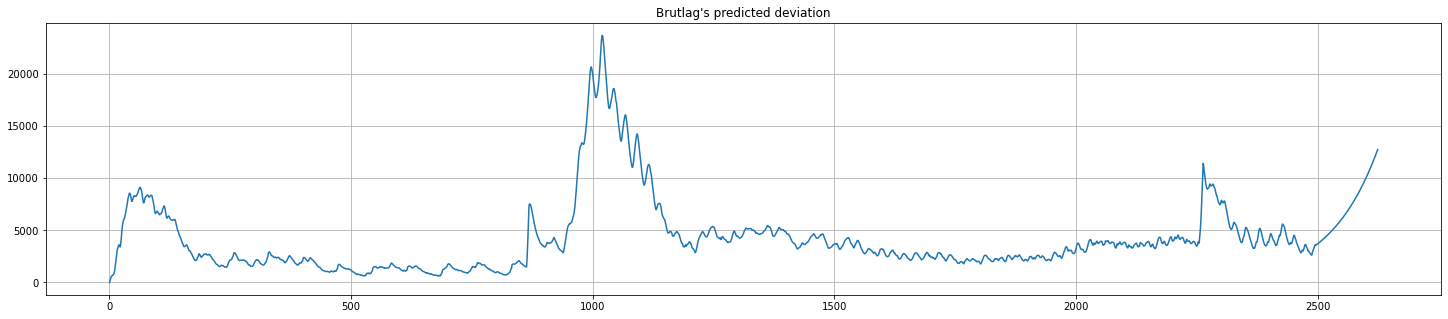

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis("tight")
plt.title("Brutlag's predicted deviation");

# Эконометрический подход

График белого шума:

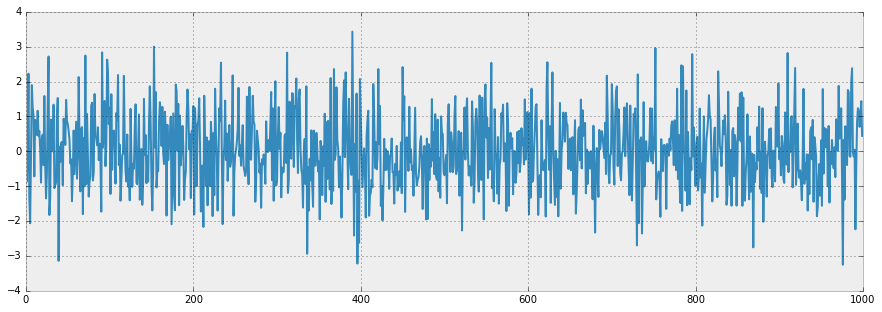

In [18]:
white_noise = np.random.normal(size=1000)
with plt.style.context("bmh"):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на его основе сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$ 

Код для отрисовки графиков

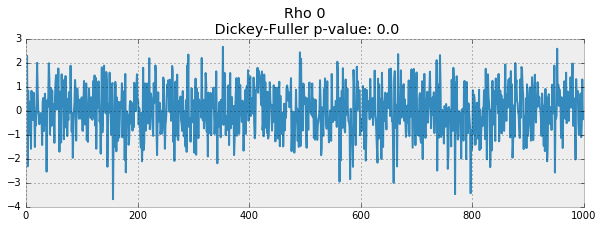

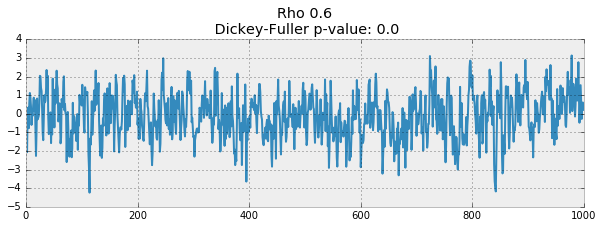

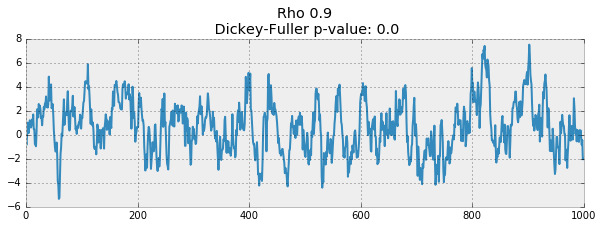

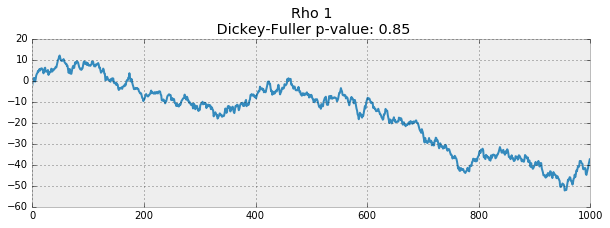

In [19]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t - 1] + w[t]

    with plt.style.context("bmh"):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title(
            "Rho {}\n Dickey-Fuller p-value: {}".format(
                rho, round(sm.tsa.stattools.adfuller(x)[1], 3)
            )
        )


for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

## Избавляемся от нестационарности и строим SARIMA

Код для отрисовки графиков

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title("Time Series Analysis Plots")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.190189


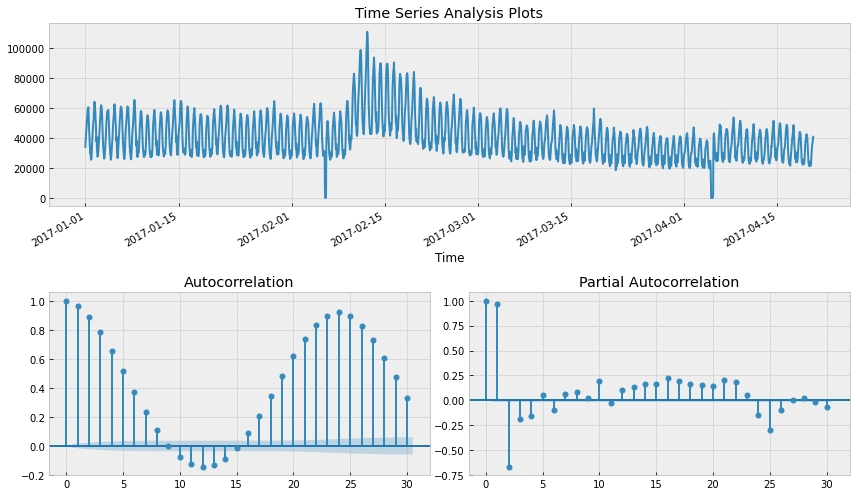

In [19]:
tsplot(dataset.Users, lags=30)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса

Критерий Дики-Фуллера: p=0.079760
Оптимальный параметр преобразования Бокса-Кокса: 0.587270


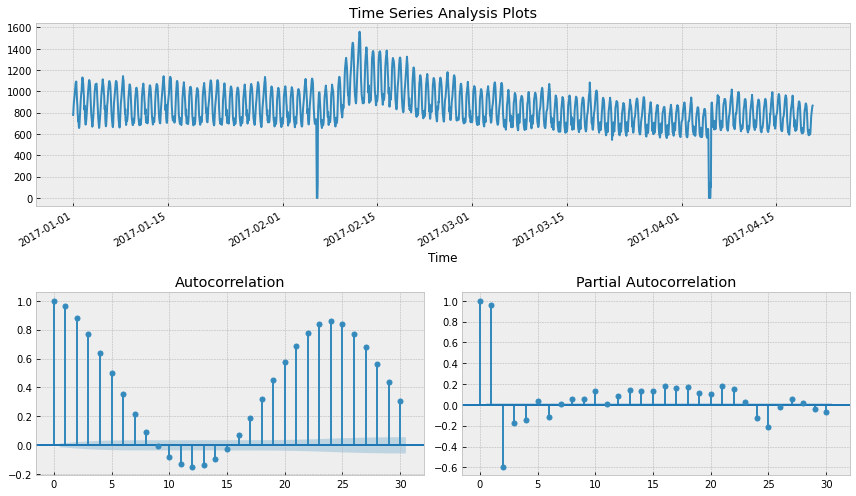

In [20]:
def invboxcox(y, lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)


data = dataset.copy()
data["Users_box"], lmbda = scs.boxcox(
    data.Users + 1
)  # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Уже лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.002571


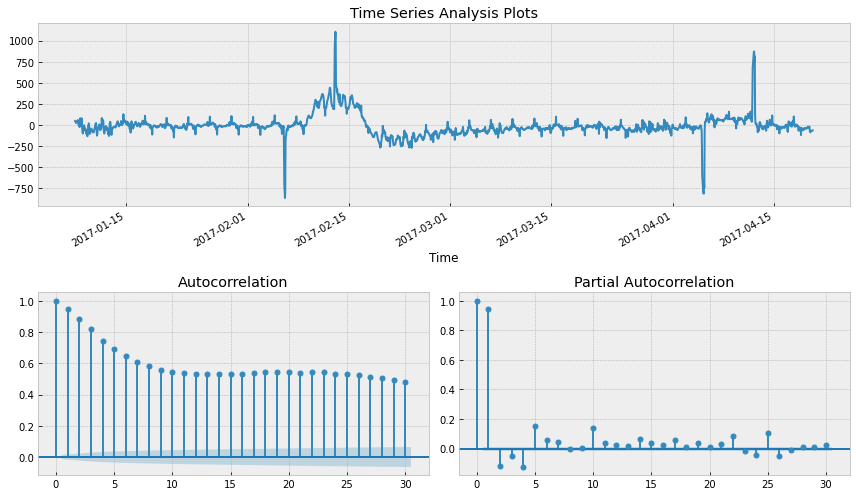

In [21]:
data["Users_box_season"] = data.Users_box - data.Users_box.shift(24 * 7)
tsplot(data.Users_box_season[24 * 7 :], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести, наконец, ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.000000


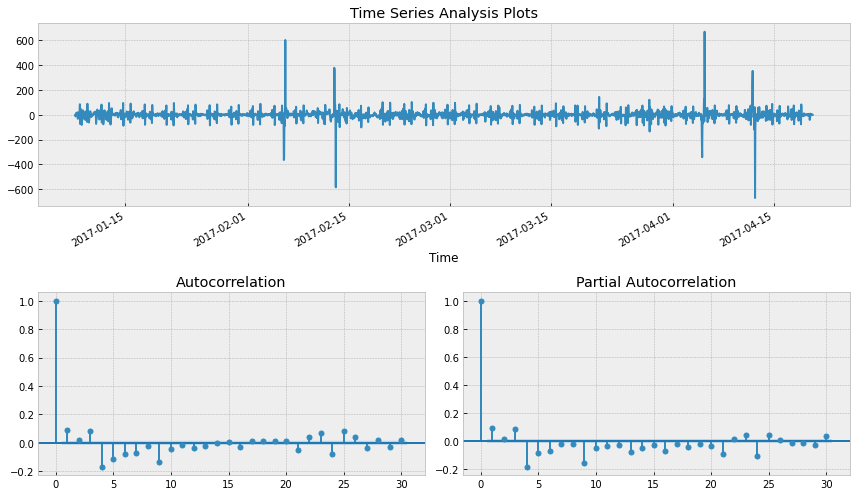

In [22]:
data["Users_box_season_diff"] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24 * 7 + 1 :], lags=30)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [23]:
ps = range(0, 5)
d = 1
qs = range(0, 4)
Ps = range(0, 5)
D = 1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [24]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            data.Users_box,
            order=(param[0], d, param[1]),
            seasonal_order=(param[3], D, param[3], 24),
        ).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        # print('wrong parameters:', param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings("default")

result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
# print(result_table.sort_values(by = 'aic', ascending=True).head())

Wall time: 5min 27s


In [25]:
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
78  (3, 3, 3, 0)  26659.118024
79  (3, 3, 4, 0)  26659.118024
75  (3, 3, 0, 0)  26659.118024
76  (3, 3, 1, 0)  26659.118024
77  (3, 3, 2, 0)  26659.118024


D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Лучшие параметры загоняем в модель:

In [26]:
%%time
best_model = sm.tsa.statespace.SARIMAX(
    data.Users_box, order=(3, d, 3), seasonal_order=(1, D, 0, 24)
).fit(disp=-1)

D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\Users\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

D:\Users\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 25.6 s


In [27]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Users_box   No. Observations:                 2625
Model:             SARIMAX(3, 1, 3)x(1, 1, [], 24)   Log Likelihood              -13076.188
Date:                             Fri, 18 Feb 2022   AIC                          26168.376
Time:                                     20:05:59   BIC                          26215.282
Sample:                                          0   HQIC                         26185.371
                                            - 2625                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3926      0.052      7.571      0.000       0.291       0.494
ar.L2          0.8555      

Проверим остатки модели:

D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Критерий Дики-Фуллера: p=0.000000


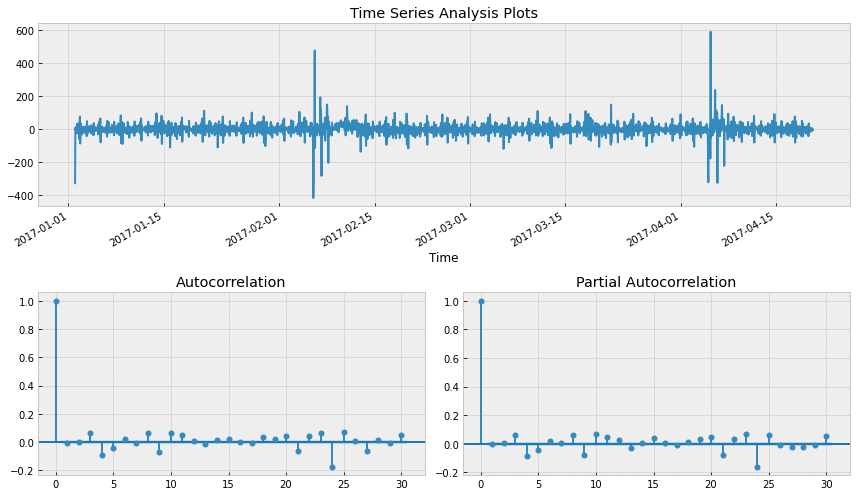

In [28]:
tsplot(best_model.resid[24:], lags=30)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

D:\Users\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

D:\Users\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:380: DeprecationWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



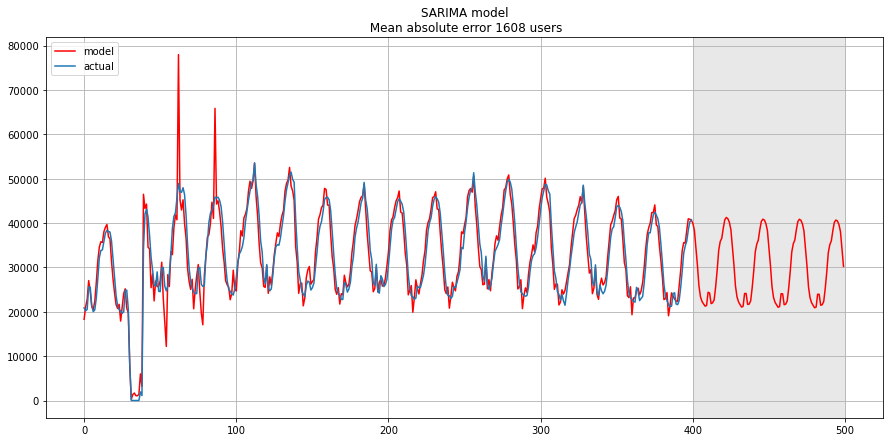

In [29]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(
    best_model.predict(start=data.shape[0], end=data.shape[0] + 100), lmbda
)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color="r", label="model")
plt.title(
    "SARIMA model\n Mean absolute error {} users".format(
        round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))
    )
)
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color="lightgrey")
plt.grid(True)

В финале получаем достаточно адекватный прогноз, в среднем модель ошибалась на 1.3 K пользователей, что очень и очень неплохо, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.

# Линейные и не очень модели на временных рядах

Снова небольшое лирическое отступление. Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – [*быстро, качественно, недорого*](http://lurkmore.to/Быстро,_качественно,_недорого). Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных (например, SARIMA), либо сложно настраиваются (хороший пример – SARIMA), либо требуют частого переобучения на новых данных (опять SARIMA), поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.

Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

# Извлечение признаков (Feature exctraction)

In [30]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Создадим новый датафрейм и добавим в него час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [34]:
data.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2017-04-20 00:00:00', '2017-04-20 01:00:00',
               '2017-04-20 02:00:00', '2017-04-20 03:00:00',
               '2017-04-20 04:00:00', '2017-04-20 05:00:00',
               '2017-04-20 06:00:00', '2017-04-20 07:00:00',
               '2017-04-20 08:00:00', '2017-04-20 09:00:00'],
              dtype='datetime64[ns]', name='Time', length=2625, freq=None)

In [40]:
data = pd.DataFrame(dataset.copy())
data.columns = ["y"]

#data.index = data.index.to_datetime()
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["is_weekend"] = data.weekday.isin([5, 6]) * 1
data.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


Посмотрим на средние по дням недели

In [41]:
code_mean(data, "weekday", "y")

D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

Помимо перечисленных преобразований для увеличения числа признаков используют и множество других метрик, например, максимальное/минимальное значение, наблюдавшееся в скользящем по ряду окне, медианы, число пиков, взвешенные дисперсии и многое другое. Автоматически этим занимается [библиотека tsfresh](https://github.com/blue-yonder/tsfresh).

Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные.

In [44]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

#    data.index = data.index.to_datetime()
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["weekday_average"] = list(
        map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
    )
    data["hour_average"] = list(
        map(code_mean(data[:test_index], "hour", "y").get, data.hour)
    )

    # выкидываем закодированные средними признаки
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

Обучим на получившихся данных простую линейную регрессию. При этом лаги будем брать начиная с двенадцатого, таким образом модель будет способна строить предсказания на 12 часов вперёд, имея фактические наблюдения за предыдущие пол дня

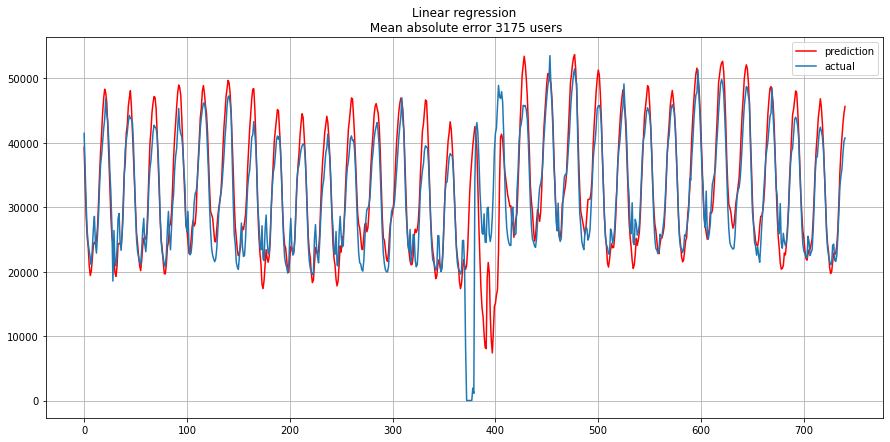

In [45]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(
    dataset.Users, test_size=0.3, lag_start=12, lag_end=48
)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(
    "Linear regression\n Mean absolute error {} users".format(
        round(mean_absolute_error(prediction, y_test))
    )
)
plt.grid(True);

Получилось достаточно неплохо, даже отбора признаков модель ошибается, в среднем, на 3K пользователей в час, и это учитывая огромный выброс в середине тестового ряда.

Также можно провести оценку модели на кросс-валидации, тому же принципу, что был использован ранее. Для этого воспользуемся функцией (с небольшими модификациями), предложенной в посте [Pythonic Cross Validation on Time Series](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)

In [46]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print("Size train set: {}".format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print("Size of each fold: {}".format(k))

    errors = np.zeros(number_folds - 1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print()
        split = float(i - 1) / i
        print(
            "Splitting the first " + str(i) + " chunks at " + str(i - 1) + "/" + str(i)
        )

        X = X_train[: (k * i)]
        y = y_train[: (k * i)]
        print(
            "Size of train + test: {}".format(X.shape)
        )  # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1) :]
        y_testFold = y[(index + 1) :]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i - 2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

D:\Users\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [47]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1838, 39)
Size of each fold: 367

Splitting the first 2 chunks at 1/2
Size of train + test: (734, 39)

Splitting the first 3 chunks at 2/3
Size of train + test: (1101, 39)

Splitting the first 4 chunks at 3/4
Size of train + test: (1468, 39)

Splitting the first 5 chunks at 4/5
Size of train + test: (1835, 39)


4613.178931508968

На 5 фолдах получили среднюю абсолютную ошибку в 4.6 K пользователей, достаточно близко к оценке качества, полученной на тестовом датасете.

Почему бы теперь не попробовать XGBoost

# Полезные ресурсы

- Статья [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) семействе моделей ARIMA и их применении для моделирования финансовых показателей (Brian Christopher)